In [1]:
import pandas as pd
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy import abs, array, triu, ones_like
from math import sqrt
import pickle

### Get historical data from the NASA POWER PROJECT API
##### Data is collected from: 1st Jan 2000 through 19th March 2022

In [2]:
url = "https://power.larc.nasa.gov/api/temporal/daily/point?start=20000101&end=20220101&latitude=-1.5177&longitude=37.2634&parameters=T2M,PS,WS10M,QV2M,PRECTOTCORR&community=AG&format=csv"

csv_path = keras.utils.get_file(fname="machakos-county-2000-2022.csv", origin=url)

In [3]:
def parse_date(x):
    return datetime.strptime(x, '%Y %j')

In [4]:
# Skip the CSV description rows
df = pd.read_csv(csv_path, skiprows=13, parse_dates={'date': ['YEAR', 'DOY']}, date_parser=parse_date, skipinitialspace=True, index_col=0)

In [5]:
df.tail()

,T2M,PS,WS10M,QV2M,PRECTOTCORR
date,,,,,
2021-12-28,20.37,86.87,2.98,13.85,3.71
2021-12-29,20.79,86.82,2.36,13.06,0.57
2021-12-30,20.97,86.76,2.55,13.00,0.83
2021-12-31,20.37,86.80,2.78,11.78,0.02
2022-01-01,19.56,86.87,2.48,11.17,0.00


In [6]:
# Get column names
df.columns

Index(['T2M', 'PS', 'WS10M', 'QV2M', 'PRECTOTCORR'], dtype='object')

In [7]:
# Remove empty values
indexes_to_drop = df.index[df['T2M'] == -999.00]
df.drop(indexes_to_drop, inplace=True)

<AxesSubplot:xlabel='PRECTOTCORR'>

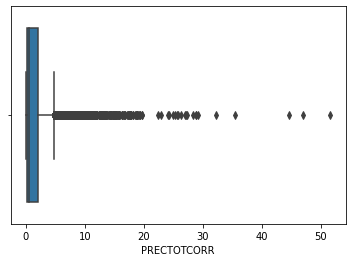

In [8]:
# Check for outliers
sns.boxplot(x=df['PRECTOTCORR'])

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

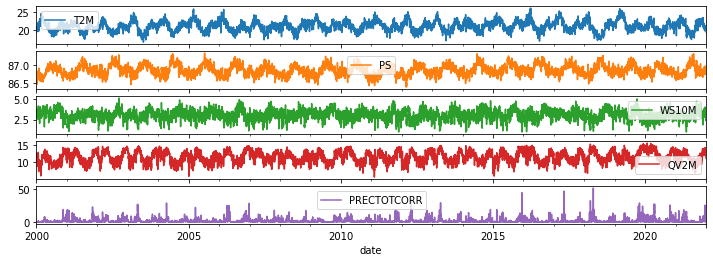

In [9]:
# Visualize trends
df.plot.line(figsize=(12, 4), subplots=True)
# plt.savefig("Sub plot", dpi=1200)

### Check for multicollinearity among predictor variables

In [10]:
correlation = df.iloc[:, :-1].corr()

<AxesSubplot:>

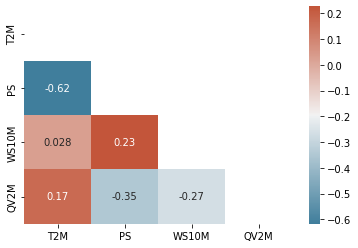

In [11]:
# Generate a mask for upper traingle
#
mask = triu(ones_like(correlation, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation, annot=True, mask=mask, cmap=cmap)

In [12]:
# split multivariate sequence into samples
def to_supervised(sequences, n_steps_back, n_steps_future):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of the pattern
        end_index = i + n_steps_back
        out_end_index = end_index + n_steps_future - 1
        # check if index is out of bound
        if out_end_index > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_index, :-1], sequences[end_index-1:out_end_index, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [13]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = scaler.fit_transform(df)

In [14]:
# X, y = to_supervised(df_scaled,n_steps_back=60,n_steps_future=30)

In [15]:
# print('Y shape', y.shape)
# print('X shape', X.shape)
# print('DF Scaled', df_scaled.shape)

In [16]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Problem Framing
#### Given the past 60 days historical weather data, forecast the rainfall for the next 3,5,7,30 days

In [17]:

def build_model(X, y):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False, recurrent_dropout=0.2, unroll=True))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

In [18]:
training_history = []
models = []
forecast_days = [3,5,7,30]
y_preds = []
train_test_data = []

In [19]:
for index, future_days in enumerate(forecast_days):
    # Convert data to supervised
    X, y = to_supervised(df_scaled, n_steps_back=60, n_steps_future=future_days)
    # split to train test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    # Append data
    train_test_data.append((x_train, x_test, y_train, y_test))
    # Build model
    # model = build_model(x_train, y_train)
    # Fit model
    # history = model.fit(x_train, y_train, epochs=60, batch_size=64, validation_split=0.3, verbose=1)
    # Append histories
    # training_history.append(history)
    # Append model
    # models.append(model)

In [ ]:
for index, model in enumerate(models):
    model.save(f'rainfall-model-{forecast_days[index]}-day')

In [20]:
# Load models
for index, forecast in enumerate(forecast_days):
    model = keras.models.load_model(f'rainfall-model-{forecast}-day')
    models.append(model)

In [21]:
for i , history in enumerate(training_history):
    plt.subplot(2, 2, i+1)
    plt.gcf().set_size_inches(15,12)
    plt.title(f'{forecast_days[i]} day forecast performance')
    plt.plot(history.history['loss'], label='Training loss' )
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Number of epochs')
    plt.legend()

In [22]:
from numpy import zeros

In [23]:
def reverse_y_scaler(data):
    data = data.ravel() # convert from 2D array into 1D array
    # create a new numpy array
    shape = (data.shape[0], 5)
    n_array = zeros(shape)
    n_array[:, -1] = data
    return n_array

In [24]:
type(train_test_data)

list

## Evaluation Metric
Evaluate each time step separately in order to:
* Comment on the skill at a particular lead time (1 day vs 3 day)
* Contrast models based on their skills at different lead times (models good at +1 day vs models good at days +5)

In [31]:
from sklearn.metrics import r2_score

In [29]:
# def coeff_determination(y_true, y_pred):
#     SS_res = K.sum(K.square(y_true - y_pred))
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return (1 - SS_res/(SS_tot + K.epsilon()))

In [32]:
model_performance = {}
inverse_y_test_pred = []
# Perform fit for each model
for (index, model) in enumerate(models):
    X_test = train_test_data.__getitem__(index)[0]
    y_test = train_test_data.__getitem__(index)[2]
    #  get prediction
    yhat = model.predict(X_test, verbose=0)

    print(y_test.shape)
    print(yhat.shape)

    inv_yhat = scaler.inverse_transform(reverse_y_scaler(yhat))[:, -1]
    inv_y_test = scaler.inverse_transform(reverse_y_scaler(y_test))[:, -1]
    inverse_y_test_pred.append((inv_y_test, inv_yhat))
    mse = mean_squared_error(inv_y_test, inv_yhat)
    rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat))
    mae = mean_absolute_error(inv_y_test, inv_yhat)
    R2 = r2_score(inv_y_test, inv_yhat)

    model_performance[f'{forecast_days[index]} day'] = {
        'mean_squared_error': mse,
        'root_mean_squared_error': rmse,
        'mean_absolute_error': mae,
        'R2': R2
    }
    


(6380, 3)
(6380, 3)
(6378, 5)
(6378, 5)
(6376, 7)
(6376, 7)
(6358, 30)
(6358, 30)


In [33]:
[print(key,':',value) for key, value in model_performance.items()]

3 day : {'mean_squared_error': 5.88795435530309, 'root_mean_squared_error': 2.426510736696438, 'mean_absolute_error': 1.3253998950575125, 'R2': 0.3717405926343107}
5 day : {'mean_squared_error': 6.038338120792621, 'root_mean_squared_error': 2.457303017699002, 'mean_absolute_error': 1.2958612204379842, 'R2': 0.35518391492061097}
7 day : {'mean_squared_error': 5.830175799812003, 'root_mean_squared_error': 2.414575697676924, 'mean_absolute_error': 1.2600699348909965, 'R2': 0.3791265733786885}
30 day : {'mean_squared_error': 6.011621129517505, 'root_mean_squared_error': 2.451860748394473, 'mean_absolute_error': 1.3729330106252258, 'R2': 0.3509185975204664}


[None, None, None, None]

[1.71 1.25 0.63]
[4.19732654 3.41037918 3.16297449]
[1.71 1.25 0.63 0.56 0.01]
[3.36420673 2.69797097 2.30102532 2.20755542 2.12382887]
[0.72 1.49 0.24 0.48 0.42 0.06 0.44]
[1.57328769 1.74012605 1.64615501 1.96157006 1.68253717 1.81142082
 1.75902218]
[5.26 1.96 1.51 0.06 0.07 0.09 1.18 0.5  0.89 1.09 3.15 1.15 2.47 0.66
 0.27 0.37 0.03 0.   0.1  0.66 0.37 0.32 0.56 0.91 1.68 0.85 0.08 0.2
 0.59 0.41]
[1.47634995 1.37485267 1.21763868 1.17857647 1.2119269  1.03380196
 1.02416392 1.08021478 0.81936469 0.96000325 1.02597166 1.05326107
 0.94615473 0.91089027 0.88032387 0.98169227 1.00055444 0.97418785
 0.87450667 0.90911793 0.96470122 0.88051538 0.80712922 0.85439907
 0.84145952 0.80391244 0.82578854 0.72136543 0.68570584 0.8637041 ]


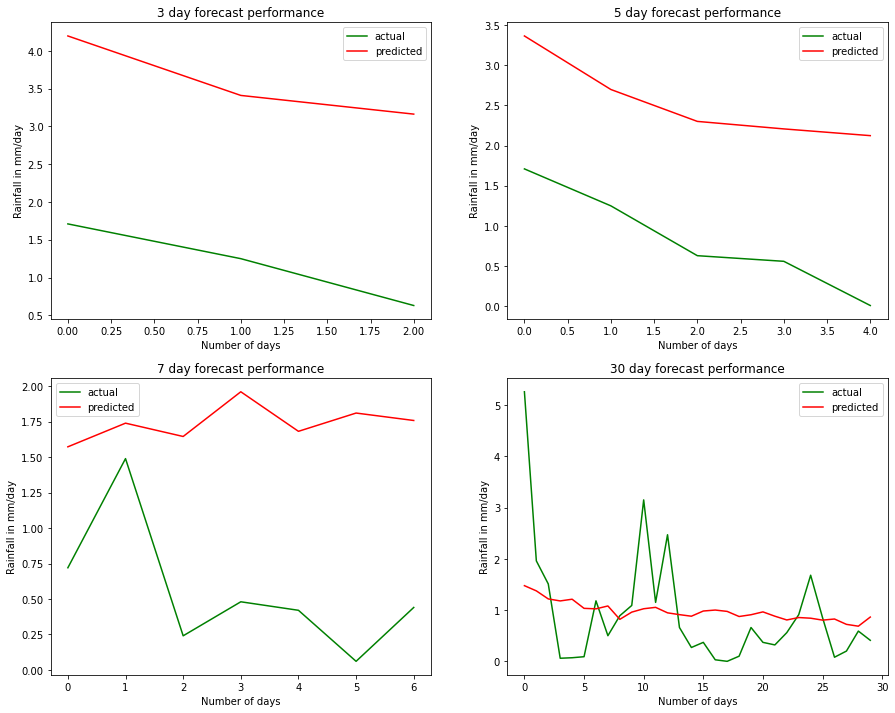

In [37]:
for i , y_val in enumerate(inverse_y_test_pred):
    actual = y_val[0]
    predicted = y_val[1]
    print(actual[:forecast_days[i]])
    print(predicted[:forecast_days[i]])
    plt.subplot(2, 2, i+1)
    plt.gcf().set_size_inches(15,12)
    plt.title(f'{forecast_days[i]} day forecast performance')
    plt.plot(list(range(0,forecast_days[i])), actual[:forecast_days[i]], color='g', label='actual')
    plt.plot(list(range(0,forecast_days[i])), predicted[:forecast_days[i]], color='r', label='predicted')
    plt.xlabel('Number of days')
    plt.ylabel('Rainfall in mm/day')
    plt.legend()

[1.71 1.25 0.63]
[4.19732654 3.41037918 3.16297449]
[1.71 1.25 0.63 0.56 0.01]
[3.36420673 2.69797097 2.30102532 2.20755542 2.12382887]
[0.72 1.49 0.24 0.48 0.42 0.06 0.44]
[1.57328769 1.74012605 1.64615501 1.96157006 1.68253717 1.81142082
 1.75902218]
[5.26 1.96 1.51 0.06 0.07 0.09 1.18 0.5  0.89 1.09 3.15 1.15 2.47 0.66
 0.27 0.37 0.03 0.   0.1  0.66 0.37 0.32 0.56 0.91 1.68 0.85 0.08 0.2
 0.59 0.41]
[1.47634995 1.37485267 1.21763868 1.17857647 1.2119269  1.03380196
 1.02416392 1.08021478 0.81936469 0.96000325 1.02597166 1.05326107
 0.94615473 0.91089027 0.88032387 0.98169227 1.00055444 0.97418785
 0.87450667 0.90911793 0.96470122 0.88051538 0.80712922 0.85439907
 0.84145952 0.80391244 0.82578854 0.72136543 0.68570584 0.8637041 ]


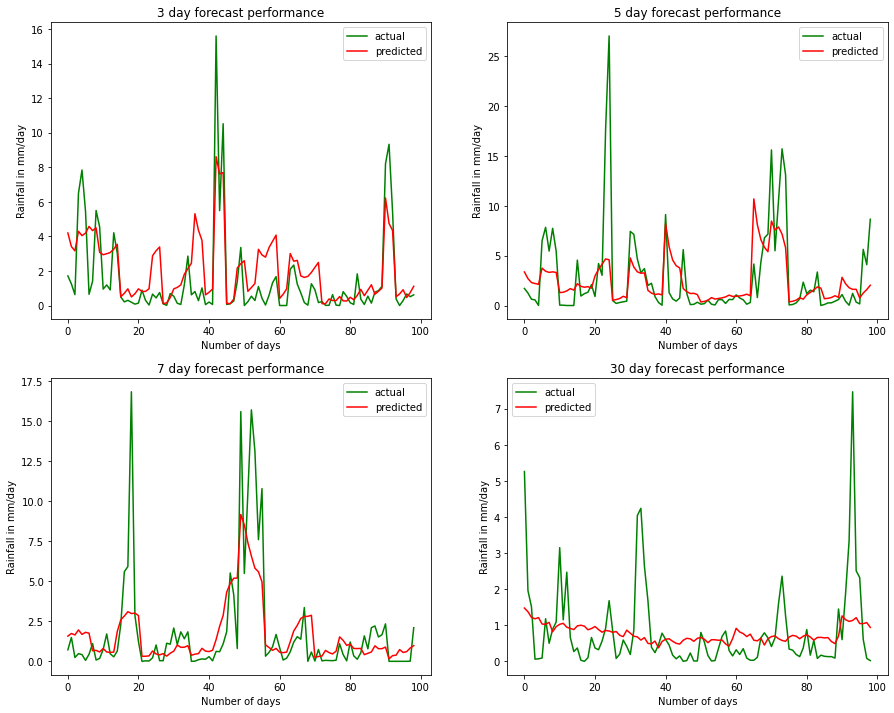

In [42]:
for i , y_val in enumerate(inverse_y_test_pred):
    actual = y_val[0]
    predicted = y_val[1]
    print(actual[:forecast_days[i]])
    print(predicted[:forecast_days[i]])
    plt.subplot(2, 2, i+1)
    plt.gcf().set_size_inches(15,12)
    plt.title(f'{forecast_days[i]} day forecast performance')
    plt.plot(list(range(0,99)), actual[:99], color='g', label='actual')
    plt.plot(list(range(0,99)), predicted[:99], color='r', label='predicted')
    plt.xlabel('Number of days')
    plt.ylabel('Rainfall in mm/day')
    plt.legend()

In [60]:
pickle.dump(scaler, open('scaler.sav', 'wb'))